In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
%cd /content/drive/MyDrive/20211/IntroML

/content/drive/MyDrive/20211/IntroML


In [34]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from matplotlib.figure import Figure 
from wordcloud import WordCloud

In [35]:
df_normal  = pd.read_csv('list_info_03.csv') # Load các thông tin các video về âm nhạc thường
# df = pd.read_csv('list_info_trending.csv') # Load thông tin các video về âm nhạc trending
df_normal.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,definition,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,hd,False,public,True,False,15496668,102261.0,NaN,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,NaN,PT1H9M43S,2d,hd,False,public,True,False,2257,11.0,NaN,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,hd,False,public,True,False,2672142,79841.0,NaN,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,NaN,10,vi,PT7M30S,2d,hd,False,public,True,False,15190,642.0,NaN,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,hd,True,public,True,False,255169,745.0,NaN,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [36]:
# Lọc ra các video âm nhạc tức categoryId là 10 - Music
df_normal = df_normal[df_normal['categoryId']==10]
# Xử lý các giá trị null trong data frame
df_normal_preprocessed = df_normal.fillna({'description':'', 'tags':'', 'defaultAudioLanguage':'', 'likeCount':0, 'dislikeCount':0, 'commentCount':0, 'topicCategories':'' })
df_normal_preprocessed.head()

,id,publishAt,title,description,channelTitle,tags,categoryId,defaultAudioLanguage,duration,dimension,definition,caption,privacyStatus,embeddable,madeForKids,viewCount,likeCount,dislikeCount,favoriteCount,commentCount,topicCategories
0,suZ-c2q3joo,2021-02-05T00:32:42Z,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,Top 15 Nhạc Remix Nghe Nhiều Nhất 💘 Kẹo Bông G...,HOA HỒNG DẠI MUSIC,"['nhac remix', 'nhạc remix', 'nhạc remix nghe ...",10,vi,PT57M27S,2d,hd,False,public,True,False,15496668,102261.0,0.0,0,5372.0,['https://en.wikipedia.org/wiki/Electronic_mus...
1,z9cON_B1NVw,2021-12-07T08:00:39Z,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,TOP Những Bài Hát ĐANG GÂY BÃO Trên Các BXH Âm...,Tình Đầu,"['nhu mot nguoi dung', 'như một người dưng', '...",10,,PT1H9M43S,2d,hd,False,public,True,False,2257,11.0,0.0,0,11.0,"['https://en.wikipedia.org/wiki/Music', 'https..."
2,JRRL0sBzuKE,2021-11-27T12:30:15Z,Họa Ức - DraTelling x MontEe (Prod. Tuanuki - ...,Nhạc này hay dã man nhể loài người?\nTất nhiên...,DraTelling,"['DraTelling', 'Dra Telling', 'dratelling', 'd...",10,vi,PT4M4S,2d,hd,False,public,True,False,2672142,79841.0,0.0,0,8832.0,['https://en.wikipedia.org/wiki/Hip_hop_music'...
3,wluTO6iyGYw,2021-12-07T12:07:03Z,Âm Nhạc Thư Giãn,✦ Link BG: \n✦ Link MP3: \n✦Kênh phụ: https://...,Tiểu Vũ - 小宇,,10,vi,PT7M30S,2d,hd,False,public,True,False,15190,642.0,0.0,0,93.0,['https://en.wikipedia.org/wiki/Music']
4,BnTZ0gVGrnQ,2021-11-14T02:00:02Z,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Tuyển Tập Nhạc Việt Hay Nhất Từng Gây Bão Các ...,Bảng Xếp Hạng VPop,"['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...",10,vi,PT2H13M13S,2d,hd,True,public,True,False,255169,745.0,0.0,0,12.0,"['https://en.wikipedia.org/wiki/Music', 'https..."


In [37]:
# Vẽ biểu đồ tròn thống kê theo số view của các video
def pieCharViewCounts(df):
    listVideo_10KView = df[df['viewCount']<100000]['id']
    listVideo_100KView = df[df['viewCount']>=100000][df['viewCount']<1e6]['id']
    listVideo_1MView = df[df['viewCount']>=1e6][df['viewCount']<1e7]['id']
    listVideo_10MView = df[df['viewCount']>=1e7][df['viewCount']<1e8]['id']
    listVideo_100MView = df[df['viewCount']>=1e8][df['viewCount']<1e9]['id']

    y = np.array([len(listVideo_10KView),
                    len(listVideo_100KView),
                    len(listVideo_1MView),
                    len(listVideo_10MView),
                    len(listVideo_100MView),
                ])
    mylabel = ['Video chuc nghin view', 'Video tram nghin view', 'Video trieu view', 'Video chuc trieu view', 'Video tram trieu view']
   
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.pie(y, labels=mylabel)
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


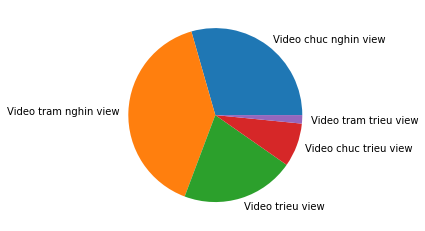

In [38]:
pieCharViewCounts(df_normal)

In [39]:
df_normal_preprocessed['tags'].fillna('', inplace=True)

In [40]:
def removeSpace(listItems, noise):
    tagsPreprocessed = []
    for item in listItems:
        if item == noise:
            tagsPreprocessed.append(item)
            continue
        item = item.replace(' ','_')
        item = item.replace(',_',', ')
        tagsPreprocessed.append(item)
    # print(tagsPreprocessed)
    return tagsPreprocessed

In [41]:
print(df_normal_preprocessed['tags'])
tagsPreprocessed = removeSpace(df_normal_preprocessed['tags'], ' ')

df_normal_preprocessed['tags'] = tagsPreprocessed

0       ['nhac remix', 'nhạc remix', 'nhạc remix nghe ...
1       ['nhu mot nguoi dung', 'như một người dưng', '...
2       ['DraTelling', 'Dra Telling', 'dratelling', 'd...
3                                                        
4       ['hoài lâm', 'bảng xếp hạng vpop', 'liên khúc ...
                              ...                        
4956    ['Michael Bublé', 'Michael Buble', 'WBR', 'War...
4957    ['Nation Boss', 'Yaksta', 'Emotions', 'Trouble...
4958    ['Violette Wautier', 'V Violette', 'The Voice ...
4959    ['เพลงลูกทุ่ง', 'แกรมมี่ โกลด์', 'grammy gold'...
4960    ['J balvin', 'jbalvin new song', 'sech', 'una ...
Name: tags, Length: 3250, dtype: object


In [42]:
df_normal_preprocessed['topicCategories'] = df_normal['topicCategories'].fillna('')

In [43]:
listTopics=[]
for index, row in df_normal_preprocessed.iterrows():
    listTopic = row['topicCategories']
    if listTopic == '':
        listTopics.append(listTopic)
        continue
    topicStr = ''
    listTopic = listTopic.replace('https://en.wikipedia.org/wiki/','')
    listTopic = listTopic.replace("'Music'",'')
    listTopic = listTopic.replace(',','')
    listTopic = listTopic.replace('[','')
    listTopic = listTopic.replace(']','')
    listTopic = listTopic.replace('\'','')
    listTopics.append(listTopic)

In [44]:
df_normal_preprocessed['topicCategories'] = listTopics

In [45]:
def convertHour(str):
    if str.find('H') == -1:
        return 0
    hour = str.split('T')[1].split('H')[0]
    return hour

def convertMinute(str):
    if str.find('M') == -1:
        return 0
    if str.find('H') != -1:
        minute = str.split('H')[1].split('M')[0]
    else:
        minute = str.split('T')[1].split('M')[0]
    return minute

def convertSecond(str):
    if str.find('S') == -1:
        return 0
    if str.find('M') == -1:
        if str.find('H') == -1:
            second = str.split('T')[1].split('S')[0]
        else:    
            second = str.split('H')[1].split('S')[0]
    else:
        second = str.split('M')[1].split('S')[0]
    return second

In [46]:
hours, minutes, seconds = [], [], []
years, months, days = [], [], []
durationInt = []
for index, row in df_normal.iterrows():
    hours.append(int(convertHour(row['duration'])))
    minutes.append(int(convertMinute(row['duration'])))
    seconds.append(int(convertSecond(row['duration'])))
    years.append(int(row['publishAt'].split('-',1)[0]))
    months.append(int(row['publishAt'].split('-',1)[1].split('-',1)[0]))
    days.append(int(row['publishAt'].split('-',2)[2].split('T')[0]))
    durationInt.append(hours[-1]*60*60+minutes[-1]*60+seconds[-1])

In [47]:
df_normal_preprocessed = df_normal_preprocessed.assign(hourDuration=hours, minuteDuration=minutes, secondDuration=seconds, yearPublished=years, monthPublished=months, dayPublished=days, durationInt = durationInt)

In [48]:
# Hàm xóa bỏ một số từ gây nhiễu
def removeStopword(texts, stopwords):
    tmpList = []
    for text in texts:
        text = text.lower()
        for stopword in stopwords:
            text = text.replace(stopword,'')
        tmpList.append(text)
    return tmpList

In [49]:
le_captions = preprocessing.LabelEncoder()
le_captions.fit(df_normal['caption'])
df_normal_preprocessed['caption'] = le_captions.transform(df_normal['caption'])

le_embeddables = preprocessing.LabelEncoder()
le_embeddables.fit(df_normal['embeddable'])
df_normal_preprocessed['embeddable'] = le_embeddables.transform(df_normal['embeddable'])

le_madeForKids = preprocessing.LabelEncoder()
le_madeForKids.fit(df_normal['madeForKids'])
df_normal_preprocessed['madeForKids'] = le_madeForKids.transform(df_normal['madeForKids'])

le_privacyStatus = preprocessing.LabelEncoder()
le_privacyStatus.fit(df_normal['privacyStatus'])
df_normal_preprocessed['privacyStatus'] = le_privacyStatus.transform(df_normal['privacyStatus'])

le_definitions = preprocessing.LabelEncoder()
le_definitions.fit(df_normal['definition'])
df_normal_preprocessed['definition'] = le_definitions.transform(df_normal['definition'])

In [50]:
def convertIfTdf(df, column, stopwords):
    data_train = df[column]
    data_train = removeStopword(data_train, stopwords)

    module_count_vector = TfidfVectorizer(stop_words=stopwords)
    model_rf_preprocess = Pipeline([('vect', module_count_vector),
                        ('tfidf', TfidfTransformer()),
                        ])
    # Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
    # Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
    data_preprocessed = module_count_vector.fit_transform(data_train)

    print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
    print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
    print(f"Xem các từ trong từ điển: {module_count_vector.vocabulary_}")
    print(type(data_preprocessed))
    return data_preprocessed


In [51]:
stopwords = [ 'official', 'mv', 'video', 'music', 'nhạc', 'âm', 'hát', 'tuyển', 'tập', 'bài', 'những', 'ca', ' x ', 'ft','feat']
X = convertIfTdf(df_normal_preprocessed,'title', stopwords)


Số lượng từ trong từ điển: 4366
Kích thước dữ liệu sau khi xử lý: (3250, 4366)
Xem các từ trong từ điển: {'top': 3522, '15': 32, 'remix': 2890, 'nghe': 2334, 'nhiều': 2410, 'nhất': 2433, 'kẹo': 1796, 'bông': 528, 'gòn': 1327, 'đường': 4156, 'quyền': 2820, 'tình': 3667, 'yêu': 4036, 'em': 1074, 'băng': 532, 'qua': 2802, 'níu': 2523, 'duyên': 1004, 'đang': 4087, 'gây': 1324, 'bão': 513, 'trên': 3575, 'các': 781, 'bxh': 499, 'như': 2428, 'một': 2282, 'người': 2377, 'dưng': 1029, 'lạ': 1977, 'thoáng': 3383, 'họa': 1509, 'ức': 4304, 'dratellingmontee': 975, 'prod': 2781, 'tuanuki': 3621, 'animate': 277, 'sino': 3119, 'thư': 3431, 'giãn': 1256, 'việt': 3812, 'hay': 1368, 'từng': 3730, 'bảng': 542, 'xếp': 3994, 'hạng': 1491, 'khúc': 1709, 'trẻ': 3604, 'tôi': 3675, 'season': 3033, 'nửa': 2561, 'hồn': 1515, 'thương': 3432, 'đau': 4088, 'thanh': 3358, 'lan': 1820, 'liveshow': 1882, 'hải': 1499, 'ngoại': 2354, 'trúc': 3584, 'sinh': 3115, 'entertainment': 1087, '60s': 142, 'búp': 531, 'bê': 518, 

In [52]:
def drawWordCloud(df, column, stopwords):
  for i in range(len(np.unique(label))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()



In [22]:
import numpy as np
from sklearn.mixture import GaussianMixture

# change it
MAX_COMPONENT = 5
lowest_bic = np.infty
bic = []
best_gmm = None

for i in range(MAX_COMPONENT):
    gmm = GaussianMixture(n_components=i).fit(X.toarray())
    bic.append(gmm.bic(X.toarray()))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm



1
2
3
4


In [25]:
best_gmm

GaussianMixture()

In [26]:
labels = gmm.predict(X.toarray())

In [56]:
def drawWordCloud(df, column, stopwords):
  for i in range(len(np.unique(labels))):
      
      #Extract cleaned text column
      data=df[df['label']==i][column].values
      data = removeStopword(data, stopwords)
      list_of_words=[];
      for sent in data:
        if type(sent)!=str:
          continue
        for word in sent.split():
          list_of_words.append(word)  
      final_text=" ".join(list_of_words)
      wordcloud = WordCloud(collocations=False).generate(final_text)
      plt.figure()
      title="\nCluster : "+str(i+1)+"\n Number of Videos : "+str(len(data))
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print('\n')


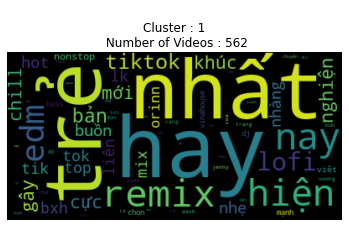

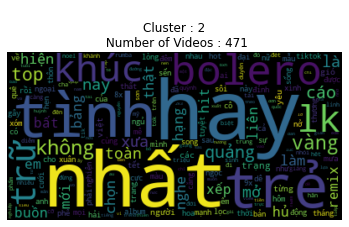

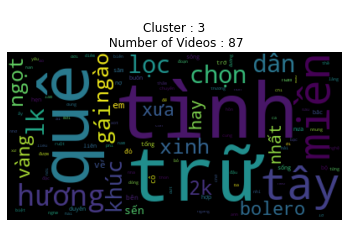

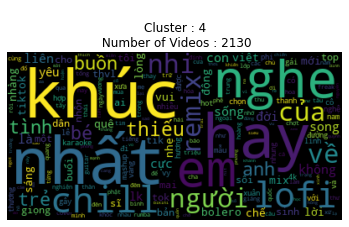

In [57]:
temp_df = df_normal_preprocessed.assign(label=labels)
drawWordCloud(temp_df,'title', stopwords)